<a href="https://colab.research.google.com/github/siddhantwade/datascienceshowcase/blob/master/model_comparison_miniproject_california_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Comparison Mini Project - California Housing

This is an on going project thgat compares the performance of various models on the task of prediciting the value of a real estate property as observed in the popular California Housing Data Set. 

To limit the scope of this project we shall be using a pre-cleaned dataset that does not show any missing value or null values. 



In [0]:
#importing required libraries

import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

#importing required models and model methods as required
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import graphviz
import pickle

In [0]:
#getting data
# I have combined the classicially available test and training sets into a single dataframe
# I have done this so during splitting I can shuffle the data as per my needs to tune performance
# the .append function can be used to combine the two sets available in sklearn library
# When using colab, the data sets are available in the Sample Data repo under the Files section of your notebook

df1 = pd.read_csv("/content/sample_data/california_housing_train.csv")
df2 = pd.read_csv("/content/sample_data/california_housing_test.csv")

#sampledata = pd.read_csv("data.csv")

df = df1.append(df2)

#creating a copy of the data set to store original file for later use
originaldf = df

In [0]:
#let's take a look at the data
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 2999
Data columns (total 9 columns):
longitude             20000 non-null float64
latitude              20000 non-null float64
housing_median_age    20000 non-null float64
total_rooms           20000 non-null float64
total_bedrooms        20000 non-null float64
population            20000 non-null float64
households            20000 non-null float64
median_income         20000 non-null float64
median_house_value    20000 non-null float64
dtypes: float64(9)
memory usage: 1.5 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc60c0f4dd8>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

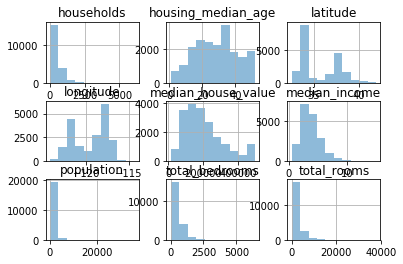

In [0]:
#let us plot the data coloumns to understand their distribution
# as we can see here many features show skew while some show a slightly gaussian distribution
plt.figure()

df.hist(alpha = 0.5)

In [0]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-119.566172,35.626750,28.627750,2637.051550,537.991800,1425.557650,499.525450,3.872132,207082.716750
std,2.003609,2.136141,12.582229,2176.314757,420.631119,1131.048487,381.729517,1.900356,115557.055856
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1451.000000,296.000000,788.000000,280.000000,2.562500,119800.000000
50%,-118.490000,34.250000,29.000000,2126.000000,434.000000,1166.000000,409.000000,3.536000,179800.000000
75%,-118.000000,37.710000,37.000000,3149.000000,647.000000,1724.000000,604.000000,4.745325,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**Note:** It can be seen above that some features have very large std deviation. This will negatively affect linear models that prefer relatively narrow distribution. 

#Observing co-relation in the features 
Building a co-relation matrix allows us to visualise how the features scale w.r.t each other. Here-in we can observe that the Number of rooms and population of a property show significant co-relation. I will not be removing any of these features though, since in this use case they depict a ground reality which I want my models to absorb.

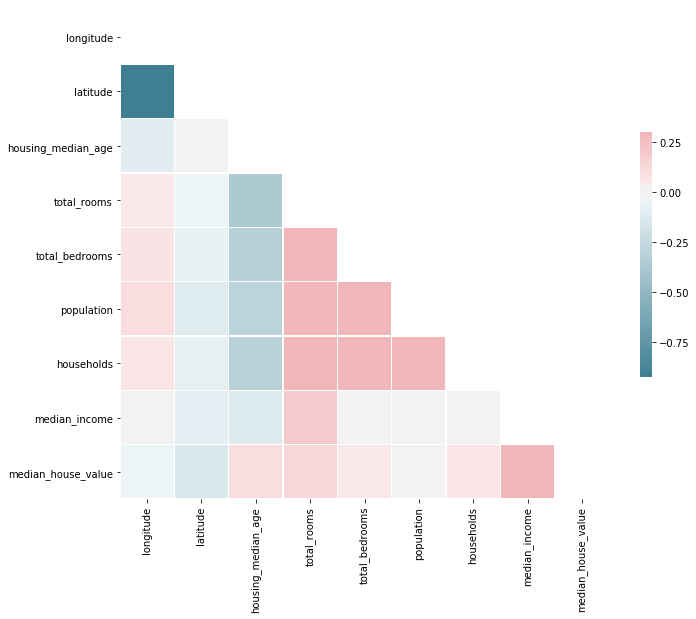

In [0]:
#building coorelation matrix

corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#Dropping features
You may choose to drop features based on your hypothesis

In [0]:
# we will now use df as the modelling set
#use list of "","","" enclosed in box braces to drop multiple cols

df = dforiginal.drop("total_bedrooms", axis = 1) 

#let's take a look at our modelling dataframe now

df.info()

#Defining Features and Target

In [0]:
#defining features
x = df.iloc[:,:-1]
#defining targets
y = df.iloc[:,-1:]



# Splitting the data

**Note** - The train_test_split method has Shuffe activated by default hence each time we execute this, it will generate different training and test set, which will induce variance in our models. Since the data shows a healthy amount of skew, our models are likely to suffer significantly.

In [0]:
#splitting the data
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30)


# Tracking scores

I am creating 2 lists viz. "scorelist" and "iteration" to track the scores of models over a few iterations. Usually I will do this to observe how the model performance changes as we adjust either data parameters of model hyper parameters. The obersvation is made using a simple 2D plot.

In [0]:
scorelist = []
iteration = [1,2,3,4,5,6,7,8,9,10]

#Using a Linear Model

Variance - is the measure of how much a model changes if the data changes. This can be observed by changing/shuffling data

**To observe varaiance, split the data before fitting the model again, the model will then show you a different score on each such fit**

In [0]:
#Fitting Linear Regressor

LR = LinearRegression()
LR.fit(xtrain,ytrain)


traininglossLR = LR.score(xtrain,ytrain)
testinglossLR = LR.score(xtest,ytest)
print("Training loss - ", traininglossLR)
print("Testing loss - ", testinglossLR)

print("Feature Weights are - \n", LR.coef_)

#Un-comment this below code and run this cell 10 times if you wish to observe the model accuracy over 10 cycles.
#scorelist.append(testinglossLR)



Training loss -  0.6383456316551955
Testing loss -  0.572104255560611
Feature Weights are - 
 [[-4.30818276e+04 -4.28273559e+04  1.15497107e+03 -8.37326991e+00
   1.14171545e+02 -3.82459179e+01  4.78929887e+01  4.03546336e+04]]


Linaer models although showing high variance will show minor differences in the weights of the features, in this case which are coefficients. A small change in the weights leads to a major change in the accuracy. As long as the data remains largely unchanged Linear Models will show minimal variance error.

[[-4.31256136e+04 -4.28653669e+04  1.15814662e+03 -8.35045320e+00
   1.14339474e+02 -3.81945464e+01  4.75119304e+01  4.03497459e+04]]
   
   [[-4.31154190e+04 -4.28257153e+04  1.15609145e+03 -8.35542878e+00
   1.14296057e+02 -3.82486762e+01  4.77164593e+01  4.03488523e+04]]
   
 
 
 [[-4.30709016e+04 -4.27887044e+04  1.15567844e+03 -8.42090820e+00
   1.14457051e+02 -3.82395169e+01  4.78606659e+01  4.03884341e+04]]
   
 [[-4.30749755e+04 -4.28063310e+04  1.15452294e+03 -8.35519986e+00
   1.14134633e+02 -3.82429840e+01  4.78399847e+01  4.03514761e+04]]

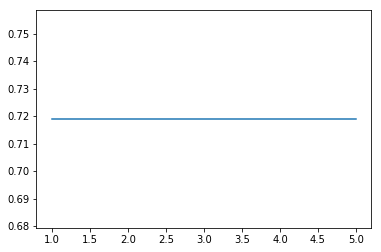

In [0]:
plt.plot(iteration, scorelist)

Below code will run the Linear Model for a set number of iterations

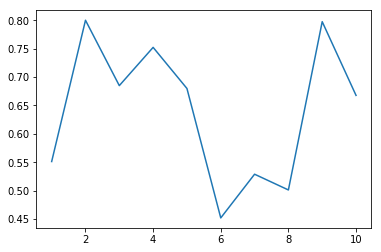

In [0]:
scorelist = []
iteration = [1,2,3,4,5,6,7,8,9,10]

for i in iteration:
  
  #splitting to display variance
  xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30, shuffle = True)

  #Fitting Linear Regressor

  LR = LinearRegression()
  LR.fit(xtrain,ytrain)


  traininglossLR = LR.score(xtrain,ytrain)
  testinglossLR = LR.score(xtest,ytest)
  #print(traininglossLR)
  #print(testinglossLR)

  #print(LR.get_params())
  
  scorelist.append(testinglossLR)
  
plt.plot(iteration, scorelist)

In [0]:
print(scorelist)

[0.7667300423265966, 0.5680314407698085, 0.5474306207153067, 0.03324451356936653, -0.04725886241146715]


In [0]:
# in case your scorelist and iterationlist length does not match, adjust either one of them
scorelist = scorelist[:-1]

#Fitting regularised liear regreesions

Regularising regression is an excellent way to optimise the weight generation for better performance and increasing fit by penalising stronger features.

Commong regularisation techniques 
L1 - Lasso (Penalises to 0, but consists of feature selection)
L2 - Ridge (Penalises to some minimum value, no feature selection)

In [0]:
#Using Ridge Regression (L2 regularisation)
from sklearn.linear_model import Ridge

ridgeLR = Ridge(alpha = 1)
ridgeLR.fit(xtrain,ytrain)


traininglossridgeLR = ridgeLR.score(xtrain,ytrain)
testinglossridgeLR = ridgeLR.score(xtest,ytest)

print(traininglossridgeLR)
print(testinglossridgeLR)

0.6380914029531282
0.7003599410978696


In [0]:
from sklearn.linear_model import Lasso

lassoLR = Ridge(alpha = 1)
lassoLR.fit(xtrain,ytrain)

traininglosslassoLR = lassoLR.score(xtrain,ytrain)
testinglosslassoLR = lassoLR.score(xtest,ytest)

print(traininglosslassoLR)
print(testinglosslassoLR)


0.6388938053782709
0.6518172539668234


**Analysis on using Linear Regression**

**Vanilla version of LR -**

Training loss : 0.6388938079

Testing loss  : 0.6518185676146591


**Ride Regression L2 -**
 
0.6388938053782709

0.6518172539668234


**Lasso Regression l1 -**

0.6388938053782709

0.6518172539668234


**Analysis -**

Although linear regression does not fit the data very well, it will not show high degree of variance, that is if we retrain the model on the same data on each such training iteration the model will perform almost the same. 

However complex models will although fit the data better, they will show high degree of variance that is the will perform differently after re-training on same data and also if the data changes slightly. 

Below is an example Ransac regressor - 
Basically the below model auto-decides which data points are outliers and models only on inliers. This model will show varaince even without resplitting data. 

**the only updside is that Ransac will not overfit the data easily**

# Using Ransac Regressor

RANSAC (RANdom SAmple Consensus) algorithm.

RANSAC is an iterative algorithm for the robust estimation of parameters from a subset of inliers from the complete data set. More information can be found in the general documentation of linear models.

**We are going to run Ransac multiple times and record observations**



In [0]:
from sklearn.linear_model import RANSACRegressor

ransacR = RANSACRegressor()
ransacR.fit(xtrain, ytrain)

#ransacR.score(xtrain,ytrain)
traininglossransacR = ransacR.score(xtrain,ytrain)
testinglossransacR = ransacR.score(xtest,ytest)

print(traininglossransacR)
print(testinglossransacR)

0.49074592331207934
0.35309512714307695


**Observations**

Iteration 1 - 

0.40279365680595725

0.5978635223695535

Iteration 2 - 

0.4895082652701116


0.6170210282185535

Iteration 3 - **Best fit**

0.5582286892065771

0.767279356068632

Iteration 4 - 

0.41852707293959845

0.6489107521146353

Accuracy of saved and loaded model
0.7119229578158638

# Saving and Re-using Models
When working with complex models, its better to save the best model for later use.

In [0]:
#saving the model using pickle

import pickle

filename = 'finalized_model.sav'
pickle.dump(ransacR, open(filename, 'wb'))

In [0]:
#Loading and using a pre-saved model

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(xtest, ytest)
print(result)

0.7119229578158638


# **Using a highly complex models**

The magic with decision trees is that although this algorithm fits the data very optimistically we have the capability to prune the tree and prevent it from overfitting data to our own liking. Meaning we have the ability to define how complex we want the model to be.

In [0]:
dtree = DecisionTreeRegressor(max_depth = 7) #max_depth = 15
dtree.fit(xtrain,ytrain)

#ransacR.score(xtrain,ytrain)
traininglossdtree = dtree.score(xtrain,ytrain)
testinglossdtree = dtree.score(xtest,ytest)

print(traininglossdtree)
print(testinglossdtree)

0.706731577794109
0.7961259250161956


**Analysis of Dtree**

Iteration 1 - 


1.0

0.1992289373083762

This means that the tree is showing no training loss, means it fits the training data 100% but performs very poorly on test data, this is another way of detecting variance.

---

Iteration 2 -

0.9997253857001949

0.4521182121500316

When we reduced the complexity of the tree to a max depth of 25 levels immediately we see a drop in ability to fit data but we see a substantial increase in ability to predict test data, this is the justification that variance has reduced in our model

---


Iteration 3- max depth 15

0.9557919969594201

0.7201287095240858


By reduct depth of tree to 15, we have marginally reduced the training accuracy but signifianctly gained prediction accuracy. This is a good tradeoff

---


**THE DEVIL OF DATA**

Now i re-split the data by executing the train test split method above, the same model that was giving us excellent result of ~71% now performs poorly on new data.

0.9561743947897237

0.6980553120732594


**let's save the current model and test if on different data**

I will save the model
Run the split again
Import the saved model 
Test it on the new data
Asses results

In [0]:
filename = 'dtree.sav'
pickle.dump(dtree, open(filename, 'wb'))



In [0]:
loaded_dtree = pickle.load(open(filename, 'rb'))
result = loaded_dtree.score(xtest, ytest)
print(result)

0.7961259250161956


As you can see above that the exported model which was earlier performing poorly, is not giving accuracy of 0.9665740174940533 on test data.

--- 

On repeating the steps again the model gives an accuracy of 
0.9379607777538903

This is a problem of variance that complex models will show, they perform poorly or unpredictably when data changes, this can be a huge issue to compensate in production. 



# Visualising your Dtrees

In case of highly complex trees, the visualisation will take some time to complete.

[Text(171.09759036144578, 203.85, 'X[7] <= 5.075\nmse = 13348609658.173\nsamples = 19970\nvalue = 207043.427'), Text(86.05301204819277, 176.67000000000002, 'X[7] <= 3.074\nmse = 8420359738.165\nsamples = 15848\nvalue = 174204.235'), Text(43.026506024096385, 149.49, 'X[1] <= 34.455\nmse = 5611083185.182\nsamples = 7599\nvalue = 135683.411'), Text(21.513253012048192, 122.31, 'X[0] <= -118.305\nmse = 5566456347.098\nsamples = 3690\nvalue = 157366.566'), Text(10.756626506024096, 95.13, 'X[0] <= -118.355\nmse = 8941876333.542\nsamples = 679\nvalue = 224643.471'), Text(5.378313253012048, 67.94999999999999, 'X[1] <= 34.165\nmse = 8642695192.933\nsamples = 416\nvalue = 241128.637'), Text(2.689156626506024, 40.77000000000001, 'X[0] <= -118.385\nmse = 11377248754.553\nsamples = 154\nvalue = 297411.11'), Text(1.344578313253012, 13.590000000000003, 'mse = 7367833269.65\nsamples = 82\nvalue = 345318.378'), Text(4.033734939759036, 13.590000000000003, 'mse = 10352747738.941\nsamples = 72\nvalue = 242

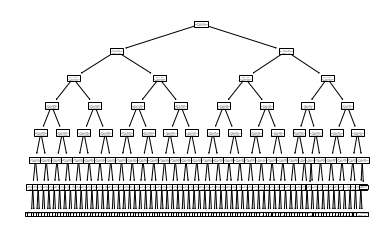

In [0]:
#sklearn has a plot_tree function to plot trees in terminal
#for larger trees without pruning, the execution will take 5-10mins
#if the tree is big then you won't be able to see individual node parameters
#for detailed visualisation you can use Graphviz library for quick results


print(plot_tree(dtree))

In [0]:
#using Graphviz
#these processes can take a long time to generate the tree, patience please


dot = export_graphviz(dtree,
                        out_file=None,
                        filled=True,
                        impurity=None,
                        )

graph = graphviz.Source(dot)
graph.render("dtree_render")

'dtree_render.pdf'

# Testing the variance of Dtrees against Linear Model

**Note-** When shuffle in the train_test_split is turned off by defining argument shuffle = False. The linar models will show close to now variance but the Dtrees will show variance. Prune the tree to reduce the variance. 


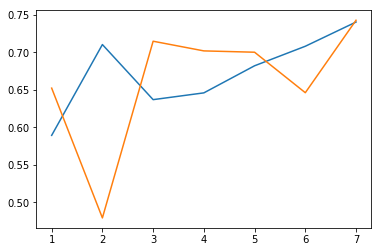

In [0]:
#READ
#first try vanila trees
#then try pruning levels
#then try pruning number of samples



scorelistvarlr = []
scorelistvardtree = []
iteration = [1,2,3,4,5,6,7]# ,8,9,10,11,12,13,14,15,16,17,18,19,20

for i in iteration:
  xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30, shuffle = True) #shuffle = False to trun of shuffle
  
  varLR = LinearRegression()
  varLR.fit(xtrain,ytrain)
  scorevarLR = varLR.score(xtest,ytest)
  
  #You can prune a dtree by defining arguments that limit its growth
  vardtree = DecisionTreeRegressor(max_depth = 7) #max_depth = 15 #min_samples_split Use
  vardtree.fit(xtrain,ytrain)
  scorevardtree = vardtree.score(xtest,ytest)
  
  
  
  scorelistvarlr.append(scorevarLR)
  scorelistvardtree.append(scorevardtree)
  

  
plt.plot(iteration,scorelistvarlr, label = 'LR')
plt.plot(iteration,scorelistvardtree, label = 'Dtree')
  


#Ensembling

Ensembling is the process of building many smaller models also known as stumps that fit a fragment of your data but working together can as an aggregated model output perform much better than a single complex model

--- 

Let's first try Gradient Boosting Ensembler

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7300168136327555


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7474828222582637


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7547757704675968


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7745963853876953


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7762903968368811


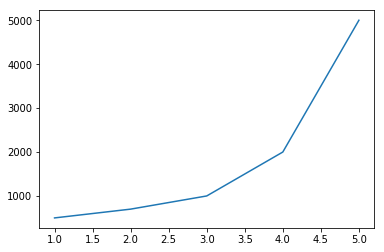

In [0]:
argumentlist = [500,700,1000,2000,5000]
iteration = [1,2,3,4,5]

for i in argumentlist:
  gbr = GradientBoostingRegressor(n_estimators = i, learning_rate = 0.03)

  gbr.fit(xtrain,ytrain)

  #ransacR.score(xtrain,ytrain)
  traininglossgbr = gbr.score(xtrain,ytrain)
  testinglossgbr = gbr.score(xtest,ytest)

  #print(traininglossgbr)
  print(testinglossgbr)
  
plt.plot(iteration, argumentlist)

**In here we do not know what the correct number of estimators or sub-models we want, hence let us cycle through a list with options**

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6067953634273251


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7390212254837795


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7816154162537913


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7970717835245664


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8091488953687959


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8127816848585412


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8171649760612585


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8173587070462222


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8201898250992563


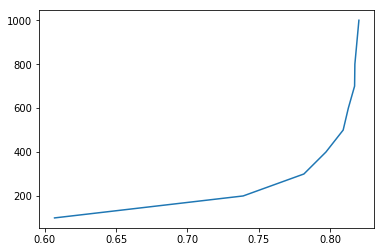

In [0]:
argumentlist = [100,200,300,400,500,600,700,800,1000]
scorelist = []

for i in argumentlist:
  gbr = GradientBoostingRegressor(n_estimators = i, learning_rate = 0.03)
  gbr.fit(xtrain,ytrain)  
  score_to_append = gbr.score(xtest,ytest)
  print(score_to_append)
  scorelist.append(score_to_append)
  
  
import matplotlib.pyplot as plt

plt.plot(scorelist, argumentlist, label='score')

The above plot gives us an understanding of how the score changes for each selection of estimators

In [0]:
#Now let's check variance of GBR by running split statement and then assesing score


#splitting the data
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30)

print(gbr.score(xtest,ytest))

0.9189803433390424


Split 1 - 0.9253486080131357

Split 2 - 0.8967617652947449

Split 3 - 0.771234655801339

Split 4 - 0.9189803433390424

---

The model shows some variance as we change the data.

In [0]:
t_iterationlist = [1,2,3,4,5,6,7,8,9,10]
t_scorelist = []

In [0]:
for i in t_iterationlist:
  t_scorelist.append(100)

In [0]:
print(t_scorelist)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


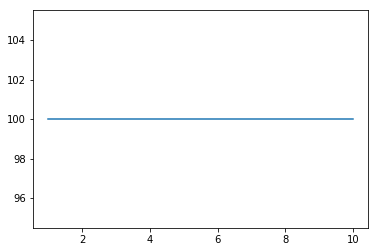

In [0]:
plt.plot(t_iterationlist,t_scorelist)

# Scaling the data for normalcy and then fitting models

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#df = scaler.fit(df)



In [0]:
scaleddf = scaler.fit_transform(df)

In [0]:
print(scaleddf)

[[ 2.62341796 -0.67260797 -1.0831221  ... -0.07210901 -1.25165577
  -1.21313424]
 [ 2.54356006 -0.57429739 -0.76520547 ... -0.0956865  -1.07989419
  -1.0989021 ]
 [ 2.49863999 -0.90668077 -0.92416378 ... -1.00211012 -1.16887974
  -1.05043998]
 ...
 [-0.06679515  0.31517926 -1.48051789 ... -0.73227881 -0.83282905
  -1.2555386 ]
 [ 1.22091354 -0.71474107  0.90385686 ... -1.27194143 -0.31643922
  -0.38581661]
 [-0.03185731 -0.56493448  1.06281518 ... -0.62748996  2.46731925
   2.53490022]]


In [0]:
scaleddf = pd.DataFrame(scaleddf, columns = ['longitude', 'latitude',	'housing_median_age',	'total_rooms',	'total_bedrooms',	'population',	'households',	'median_income',	'median_house_value'])

In [0]:
scaleddf.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04
mean,-4.224638e-15,-3.277933e-15,1.975420e-16,-7.558953e-17,-1.300682e-16,-7.552847e-17,1.319722e-16,-1.111111e-16,-3.298029e-16
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00
min,-2.387665e+00,-1.445048e+00,-2.195830e+00,-1.210816e+00,-1.276665e+00,-1.257765e+00,-1.305998e+00,-1.774571e+00,-1.662283e+00
25%,-1.109939e+00,-7.943258e-01,-8.446846e-01,-5.449952e-01,-5.753208e-01,-5.637014e-01,-5.750955e-01,-6.891682e-01,-7.553403e-01
50%,5.371302e-01,-6.445192e-01,2.958612e-02,-2.348302e-01,-2.472342e-01,-2.294898e-01,-2.371515e-01,-1.768829e-01,-2.361033e-01
75%,7.816951e-01,9.752646e-01,6.654194e-01,2.352423e-01,2.591604e-01,2.638700e-01,2.736942e-01,4.595006e-01,5.012133e-01
max,2.623418e+00,2.960202e+00,1.857607e+00,1.622046e+01,1.404355e+01,3.028809e+01,1.462453e+01,5.855874e+00,2.534900e+00


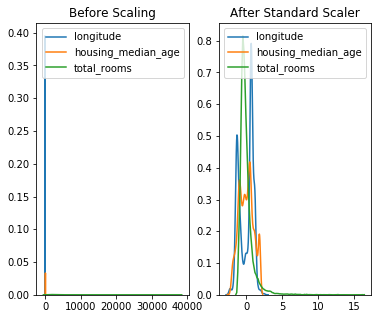

In [0]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(df['longitude'], ax=ax1)
sns.kdeplot(df['housing_median_age'], ax=ax1)
sns.kdeplot(df['total_rooms'], ax=ax1)
ax2.set_title('After Standard Scaler')
sns.kdeplot(scaleddf['longitude'], ax=ax2)
sns.kdeplot(scaleddf['housing_median_age'], ax=ax2)
sns.kdeplot(scaleddf['total_rooms'], ax=ax2)
plt.show()

#Fitting on scaled data


In [0]:
x = scaleddf.iloc[:,:-1]
y = scaleddf.iloc[:,-1:]

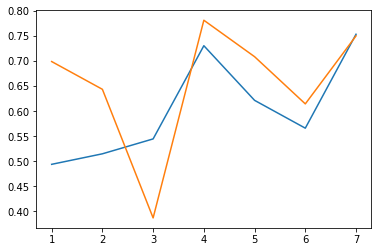

In [0]:
#READ
#first try vanila trees
#then try pruning levels
#then try pruning number of samples



scorelistvarlr = []
scorelistvardtree = []
iteration = [1,2,3,4,5,6,7]# ,8,9,10,11,12,13,14,15,16,17,18,19,20

for i in iteration:
  xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30, shuffle = True) #shuffle = False to trun of shuffle
  
  varLR = LinearRegression()
  varLR.fit(xtrain,ytrain)
  scorevarLR = varLR.score(xtest,ytest)
  
  #You can prune a dtree by defining arguments that limit its growth
  vardtree = DecisionTreeRegressor(max_depth = 7) #max_depth = 15 #min_samples_split Use
  vardtree.fit(xtrain,ytrain)
  scorevardtree = vardtree.score(xtest,ytest)
  
  
  
  scorelistvarlr.append(scorevarLR)
  scorelistvardtree.append(scorevardtree)
  

  
plt.plot(iteration,scorelistvarlr, label = 'LR')
plt.plot(iteration,scorelistvardtree, label = 'Dtree')

#Fitting on normalised data

**Normalisation**

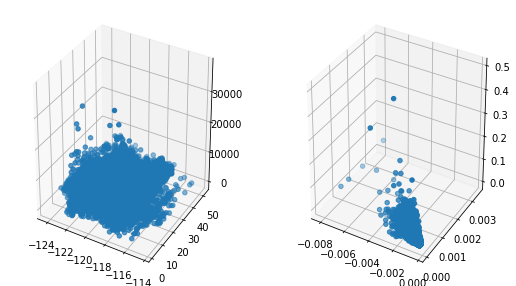

In [0]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing


scaler = preprocessing.Normalizer()
normaliseddf = scaler.fit_transform(df)

normaliseddf = pd.DataFrame(normaliseddf, columns = ['longitude', 'latitude',	'housing_median_age',	'total_rooms',	'total_bedrooms',	'population',	'households',	'median_income',	'median_house_value'])



fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.scatter(df['longitude'], df['housing_median_age'], df['total_rooms'])
ax2.scatter(normaliseddf['longitude'], normaliseddf['housing_median_age'], normaliseddf['total_rooms'])
plt.show()

In [0]:
x = normaliseddf.iloc[:,:-1]
y = normaliseddf.iloc[:,-1:]

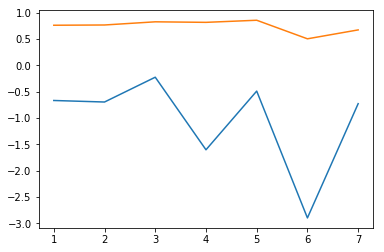

In [0]:
#READ
#first try vanila trees
#then try pruning levels
#then try pruning number of samples

scorelistvarlr = []
scorelistvardtree = []
iteration = [1,2,3,4,5,6,7]# ,8,9,10,11,12,13,14,15,16,17,18,19,20

for i in iteration:
  xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30, shuffle = True) #shuffle = False to trun of shuffle
  
  varLR = LinearRegression()
  varLR.fit(xtrain,ytrain)
  scorevarLR = varLR.score(xtest,ytest)
  
  #You can prune a dtree by defining arguments that limit its growth
  vardtree = DecisionTreeRegressor(max_depth = 7) #max_depth = 15 #min_samples_split Use
  vardtree.fit(xtrain,ytrain)
  scorevardtree = vardtree.score(xtest,ytest)
  
  
  
  scorelistvarlr.append(scorevarLR)
  scorelistvardtree.append(scorevardtree)
  

  
plt.plot(iteration,scorelistvarlr, label = 'LR')
plt.plot(iteration,scorelistvardtree, label = 'Dtree')

In [0]:
y.info()

In [0]:
print(ada.score(xtrain,ytrain))

0.0471206810215323


# Let's use cross validation to sample data sets

Corssvalidation seems to be the most effective way of countering variance when generating the final model.

In [0]:

scorelistada = []

iteration = [1,2,3,4,5] #,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20

for i in iteration:
  xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30, shuffle = True)
  scores = cross_val_score(LR, x, y, cv=7)
  print(scores)

[0.4717486  0.57580857 0.49556648 0.55322819 0.70919436 0.6569922
 0.61498799]
[0.4717486  0.57580857 0.49556648 0.55322819 0.70919436 0.6569922
 0.61498799]
[0.4717486  0.57580857 0.49556648 0.55322819 0.70919436 0.6569922
 0.61498799]
[0.4717486  0.57580857 0.49556648 0.55322819 0.70919436 0.6569922
 0.61498799]
[0.4717486  0.57580857 0.49556648 0.55322819 0.70919436 0.6569922
 0.61498799]


In [0]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 30, shuffle = True)
scores = cross_val_score(LR, x, y, cv=5)
print(scores)

[0.55730779 0.53843763 0.62391715 0.67984301 0.64000578]
